# Multiple changepoint detection and Bayesian model selection
Task: Changepoint detection with multiple changepoints

In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

In [2]:
import tensorflow, tensorflow_probability
print(tensorflow.__version__)
print(tensorflow.keras.__version__)
print(tensorflow_probability.__version__)

2.3.0
2.4.0
0.11.0


In [3]:
#b = tfd.Bernoulli(logits=tf.zeros([3, 5, 7, 9])) #crashes

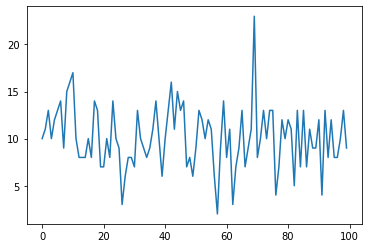

In [4]:
x = tfd.Poisson(10).sample(100)
plt.plot(x)

Consider a changepoint detection task: events happen at a rate that changes over time, driven by sudden shifts in the (unobserved) state of some system or process generating the data. For example, we might observe a series of counts like the following:

In [5]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

In [6]:
observed_counts = tf.concat(
    [tfd.Poisson(rate).sample(num_steps)
     for (rate, num_steps) in zip(true_rates, true_durations)], axis=0)

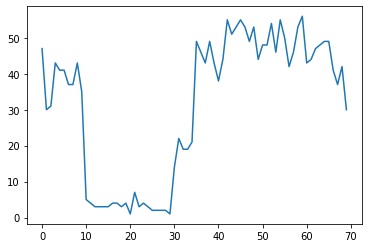

In [7]:
plt.plot(observed_counts)

These could represent the number of failures in a datacenter, number of visitors to a webpage, number of packets on a network link, etc.

Note it's not entirely apparent how many distinct system regimes there are just from looking at the data. Can you tell where each of the three switchpoints occurs?

## Known number of states

We'll first consider the (perhaps unrealistic) case where the number of unobserved states is known a priori. Here, we'd assume we know there are four latent states.

We model this problem as a switching (inhomogeneous) Poisson process: at each point in time, the number of events that occur is Poisson distributed, and the *rate* of events is determined by the unobserved system state $z_t$:

$$x_t \sim \text{Poisson}(\lambda_{z_t})$$

The latent states are discrete: $z_t \in \{1, 2, 3, 4\}$, so $\lambda = [\lambda_1, \lambda_2, \lambda_3, \lambda_4]$ is a simple vector containing a Poisson rate for each state. To model the evolution of states over time, we'll define a simple transition model $p(z_t | z_{t-1})$: let's say that at each step we stay in the previous state with some probability $p$, and with probability $1-p$ we transition to a different state uniformly at random. The initial state is also chosen uniformly at random, so we have:

$$
\begin{align*}
z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\
z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right)
\end{align*}$$

These assumptions correspond to a [hidden Markov model](http://mlg.eng.cam.ac.uk/zoubin/papers/ijprai.pdf) with Poisson emissions. We can encode them in TFP using `tfd.HiddenMarkovModel`. First, we define the transition matrix and the uniform prior on the initial state:

In [8]:
num_states = 4
initial_state_logits = tf.zeros([num_states]) # uniform distribution
print("Initial state logits:\n{}".format(initial_state_logits))

Initial state logits:
[0. 0. 0. 0.]


In [9]:
daily_change_prob = 0.05
transition_probs = tf.fill([num_states, num_states],
                           daily_change_prob / (num_states - 1))

print(daily_change_prob / (num_states - 1))
print(transition_probs)
print()
transition_probs = tf.linalg.set_diag(transition_probs,
                                      tf.fill([num_states],
                                              1 - daily_change_prob))


print("Transition matrix:\n{}".format(transition_probs))

0.016666666666666666
tf.Tensor(
[[0.01666667 0.01666667 0.01666667 0.01666667]
 [0.01666667 0.01666667 0.01666667 0.01666667]
 [0.01666667 0.01666667 0.01666667 0.01666667]
 [0.01666667 0.01666667 0.01666667 0.01666667]], shape=(4, 4), dtype=float32)

Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


Next, we build a `tfd.HiddenMarkovModel` distribution, using a trainable variable to represent the rates associated with each system state. We parameterize the rates in log-space to ensure they are positive-valued.

In [10]:
# Define variable to represent the unknown log rates.
trainable_log_rates = tf.Variable(
  tf.math.log(tf.reduce_mean(observed_counts)) +
  tf.random.stateless_normal([num_states], seed=(42, 42)),
  name='log_rates')

In [11]:
tf.random.stateless_normal([num_states], seed=(42, 42))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.08494142, 0.12767458, 2.0457768 , 0.8117064 ], dtype=float32)>

In [12]:
print(trainable_log_rates.numpy())

[3.530839  3.5735722 5.4916744 4.257604 ]


In [13]:
rates = tf.exp(trainable_log_rates)
print("Inferred rates (before training): {}".format(rates))

Inferred rates (before training): [ 34.152607  35.643692 242.6632    70.64053 ]


In [14]:
hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

In [15]:
hmm.log_prob(observed_counts)

<tf.Tensor: shape=(), dtype=float32, numpy=-749.3515>

In [16]:
tf.math.log(tf.reduce_mean(observed_counts))

<tf.Tensor: shape=(), dtype=float32, numpy=3.4458976>

Finally, we define the model's total log density, including a weakly-informative LogNormal prior on the rates, and run an optimizer to compute the [maximum a posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) fit to the observed count data.

In [17]:
print(tfd.LogNormal(5, 5))

tfp.distributions.LogNormal("LogNormal", batch_shape=[], event_shape=[], dtype=float32)


Text(0, 0.5, 'Negative log marginal likelihood')

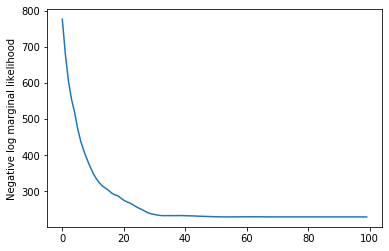

In [18]:
rate_prior = tfd.LogNormal(5, 5)

#trainable_log_rates (log(target) 값)와 state trainsition 을 위한 hmm 모델 최적화
def log_prob():
    return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

In [19]:
hmm.log_prob(observed_counts)

<tf.Tensor: shape=(), dtype=float32, numpy=-206.67502>

In [20]:
tf.math.log(tf.reduce_mean(observed_counts))

<tf.Tensor: shape=(), dtype=float32, numpy=3.4458976>

In [21]:
print(trainable_log_rates.numpy())

[1.1196312 3.6452262 3.8738348 2.9451692]


In [22]:
rates = tf.exp(trainable_log_rates)
print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rates))

Inferred rates: [ 3.063724 38.291435 48.12659  19.01388 ]
True rates: [40, 3, 20, 50]


It worked! Note that the latent states in this model are identifiable only up to permutation, so the rates we recovered are in a different order, and there's a bit of noise, but generally they match pretty well.

### Recovering the state trajectory

Now that we've fit the model, we might want to reconstruct *which* state the model believes the system was in at each timestep.

This is a *posterior inference* task: given the observed counts $x_{1:T}$ and model parameters (rates) $\lambda$, we want to infer the sequence of discrete latent variables, following the posterior distribution $p(z_{1:T} | x_{1:T}, \lambda)$. In a hidden Markov model, we can efficiently compute marginals and other properties of this distribution using standard message-passing algorithms. In particular, the `posterior_marginals` method will efficiently compute (using the [forward-backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm)) the marginal probability distribution $p(Z_t = z_t | x_{1:T})$ over the discrete latent state $Z_t$ at each timestep $t$.

In [23]:
# Runs forward-backward algorithm to compute marginal posteriors.
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()

In [24]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
    ax2.set_title(title)
    ax2.set_xlabel("time")
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)

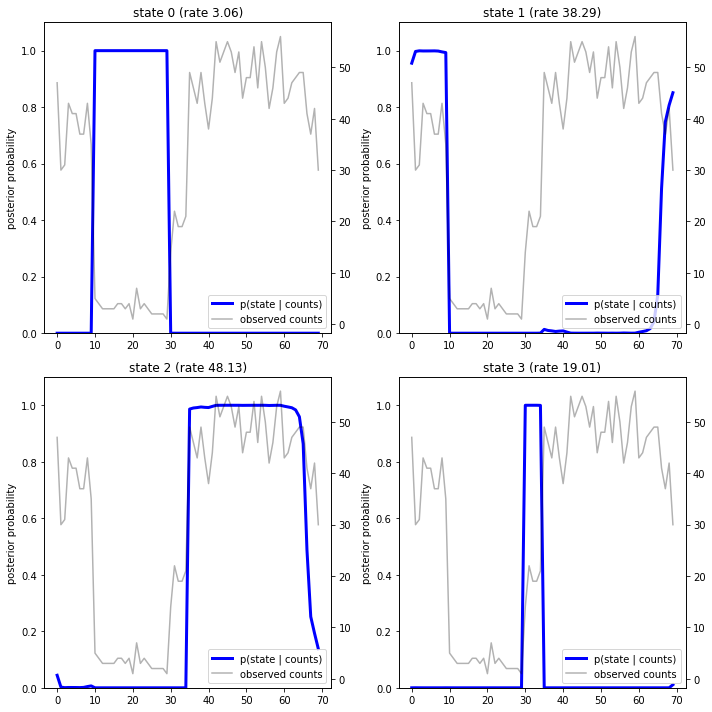

In [25]:
fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs[:, 0],
                     title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs[:, 1],
                     title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs[:, 2],
                     title="state 2 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4),
                     posterior_probs[:, 3],
                     title="state 3 (rate {:.2f})".format(rates[3]))
plt.tight_layout()

In this (simple) case, we see that the model is usually quite confident: at most timesteps it assigns essentially all probability mass to a single one of the four states. Luckily, the explanations look reasonable!

We can also visualize this posterior in terms of the rate associated with the *most likely* latent state at each timestep, condensing the probabilistic posterior into a single explanation:

In [26]:
most_probable_states = hmm.posterior_mode(observed_counts)
most_probable_rates = tf.gather(rates, most_probable_states)

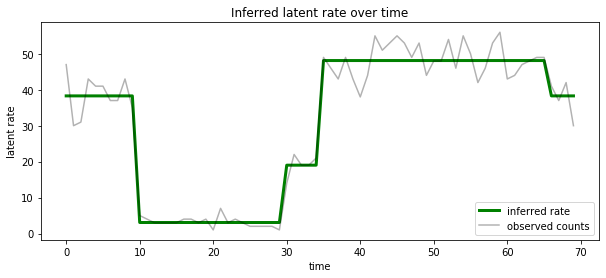

In [27]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

TODO: Unknown number of states

https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection?hl=en